1.Price: The price of the house.

2.Area: The total area of the house in square feet.

3.Bedrooms: The number of bedrooms in the house.

4.Bathrooms: The number of bathrooms in the house.

5.Stories: The number of stories in the house.

6.Mainroad: Whether the house is connected to the main road (Yes/No).

7.Guestroom: Whether the house has a guest room (Yes/No).

8.Basement: Whether the house has a basement (Yes/No).

9.Hot water heating: Whether the house has a hot water heating system (Yes/No).

10.Airconditioning: Whether the house has an air conditioning system (Yes/No).

11.Parking: The number of parking spaces available within the house.

12.Prefarea: Whether the house is located in a preferred area (Yes/No).

13.Furnishing status: The furnishing status of the house (Fully Furnished, Semi-Furnished, Unfurnished).

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

### Importing and Analyzing Data

In [126]:
df=pd.read_csv("dataset/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [127]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

#### Verify if in dataset are some null values or dublicates 
If True:

        clean_data()

else:

        continue()


In [128]:
df.isna().sum()



price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [129]:
df.duplicated().sum()

np.int64(0)

#### Price Variation

In [154]:
min_price=df["price"].min()
max_price=df["price"].max()
print("Min price in dataset:",min_price,"\n")

print("Max price in dataset ",max_price)

Min price in dataset: 1750000 

Max price in dataset  13300000


In [157]:
mean_point=df["price"].mean()
print(f"Mean: {mean_point:.3f} $")

Mean: 4766729.248 $


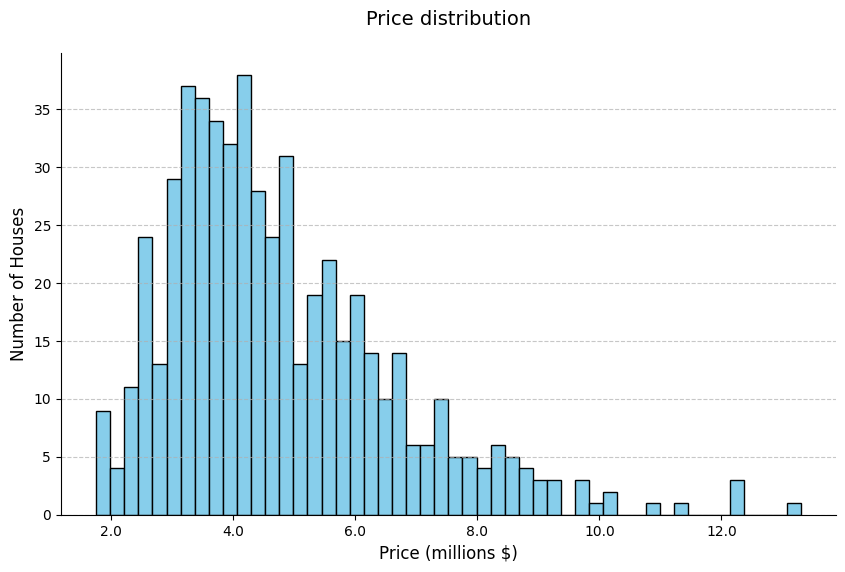

In [132]:
def plot_price_distribution(df, price_column="price"):
    plt.figure(figsize=(10, 6))

    prices_in_millions = df[price_column] / 1_000_000

    plt.hist(prices_in_millions, bins=50, color="skyblue", edgecolor="black")

    plt.title("Price distribution", fontsize=14, pad=20)
    plt.xlabel(
        "Price (millions $)", fontsize=12
    )  
    plt.ylabel("Number of Houses", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}"))

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.show()


plot_price_distribution(df)

In [133]:
print(df.dtypes)

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object


### Feature Engineering

Create 2 new columns: "price_per_sqft" and "bathroom_per_bedroom"

In [134]:
df["price_per_sqft"] = df["price"] / df["area"]
df["bathroom_per_bedroom"] = df["bathrooms"] / (df["bedrooms"] + 1)

df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_sqft,bathroom_per_bedroom
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,1792.452830,0.400000
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,1367.187500,0.800000
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,1229.919679,0.500000
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,1628.666667,0.400000
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,1537.735849,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished,606.666667,0.333333
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished,736.312500,0.250000
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished,483.425414,0.333333
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished,601.374570,0.250000


### Handle Outliers

In [135]:
from sklearn.covariance import EllipticEnvelope


def handle_outliers(df, contamination=0.01):
    """
    Select only number columns and determine outliers and handle them using Elliptic Envelope.

    """
    predictors = df.select_dtypes(include=["number"]).columns.drop(
        "price", errors="ignore"
    )

    envelope = EllipticEnvelope(contamination=contamination)
    envelope.fit(df[predictors])

    predictions = envelope.predict(df[predictors])

    df_outliers = df[predictions == -1].reset_index(drop=True)
    df_clean = df[predictions == 1].reset_index(drop=True)

    print(f"Original dataset size: {df.shape[0]} rânduri")
    print(f"Cleaned dataset size: {df_clean.shape[0]} rânduri")
    print(f"Număr de outlieri eliminați: {df.shape[0] - df_clean.shape[0]}")
    print("\nPrețurile caselor detectate ca outlieri:")
    print(df_outliers["price"].to_string(index=False))

    return df_clean

df_no_outliers= handle_outliers(df)

Original dataset size: 545 rânduri
Cleaned dataset size: 539 rânduri
Număr de outlieri eliminați: 6

Prețurile caselor detectate ca outlieri:
12250000
 8120000
 5565000
 4340000
 3500000
 1960000


### Data Preprocessing:Convert string columns to numbers

#### Transform string columns yes/no to numeric

In [136]:
yes_no_columns = [
    col
    for col in df_no_outliers.columns
    if df_no_outliers[col].nunique() == 2 and set(df_no_outliers[col].unique()) == {"yes", "no"}
]

print("yes/no columns are:")

print(yes_no_columns)

yes/no columns are:
['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']


In [137]:
for col in yes_no_columns:
    df_no_outliers[col] = df_no_outliers[col].map({"yes": 1, "no": 0})

#### OneHotEncoder for Furnishing Status

In [138]:
furnish_status_encoder = OneHotEncoder()

furnish_status_encoded = furnish_status_encoder.fit_transform(
    df_no_outliers[["furnishingstatus"]]
).toarray()

encoded_df = pd.DataFrame(
    furnish_status_encoded,
    columns=furnish_status_encoder.get_feature_names_out(["furnishingstatus"]),
).astype(int)

df_no_outliers = pd.concat([df_no_outliers, encoded_df], axis=1)

df_no_outliers = df_no_outliers.drop("furnishingstatus", axis=1)

In [139]:
df_no_outliers

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,price_per_sqft,bathroom_per_bedroom,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1792.452830,0.400000,1,0,0
1,12250000,9960,3,2,2,1,0,1,0,0,2,1,1229.919679,0.500000,0,1,0
2,12215000,7500,4,2,2,1,0,1,0,1,3,1,1628.666667,0.400000,1,0,0
3,11410000,7420,4,1,2,1,1,1,0,1,2,0,1537.735849,0.200000,1,0,0
4,10850000,7500,3,3,1,1,0,1,0,1,2,1,1446.666667,0.750000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1820000,3000,2,1,1,1,0,1,0,0,2,0,606.666667,0.333333,0,0,1
535,1767150,2400,3,1,1,0,0,0,0,0,0,0,736.312500,0.250000,0,1,0
536,1750000,3620,2,1,1,1,0,0,0,0,0,0,483.425414,0.333333,0,0,1
537,1750000,2910,3,1,1,0,0,0,0,0,0,0,601.374570,0.250000,1,0,0


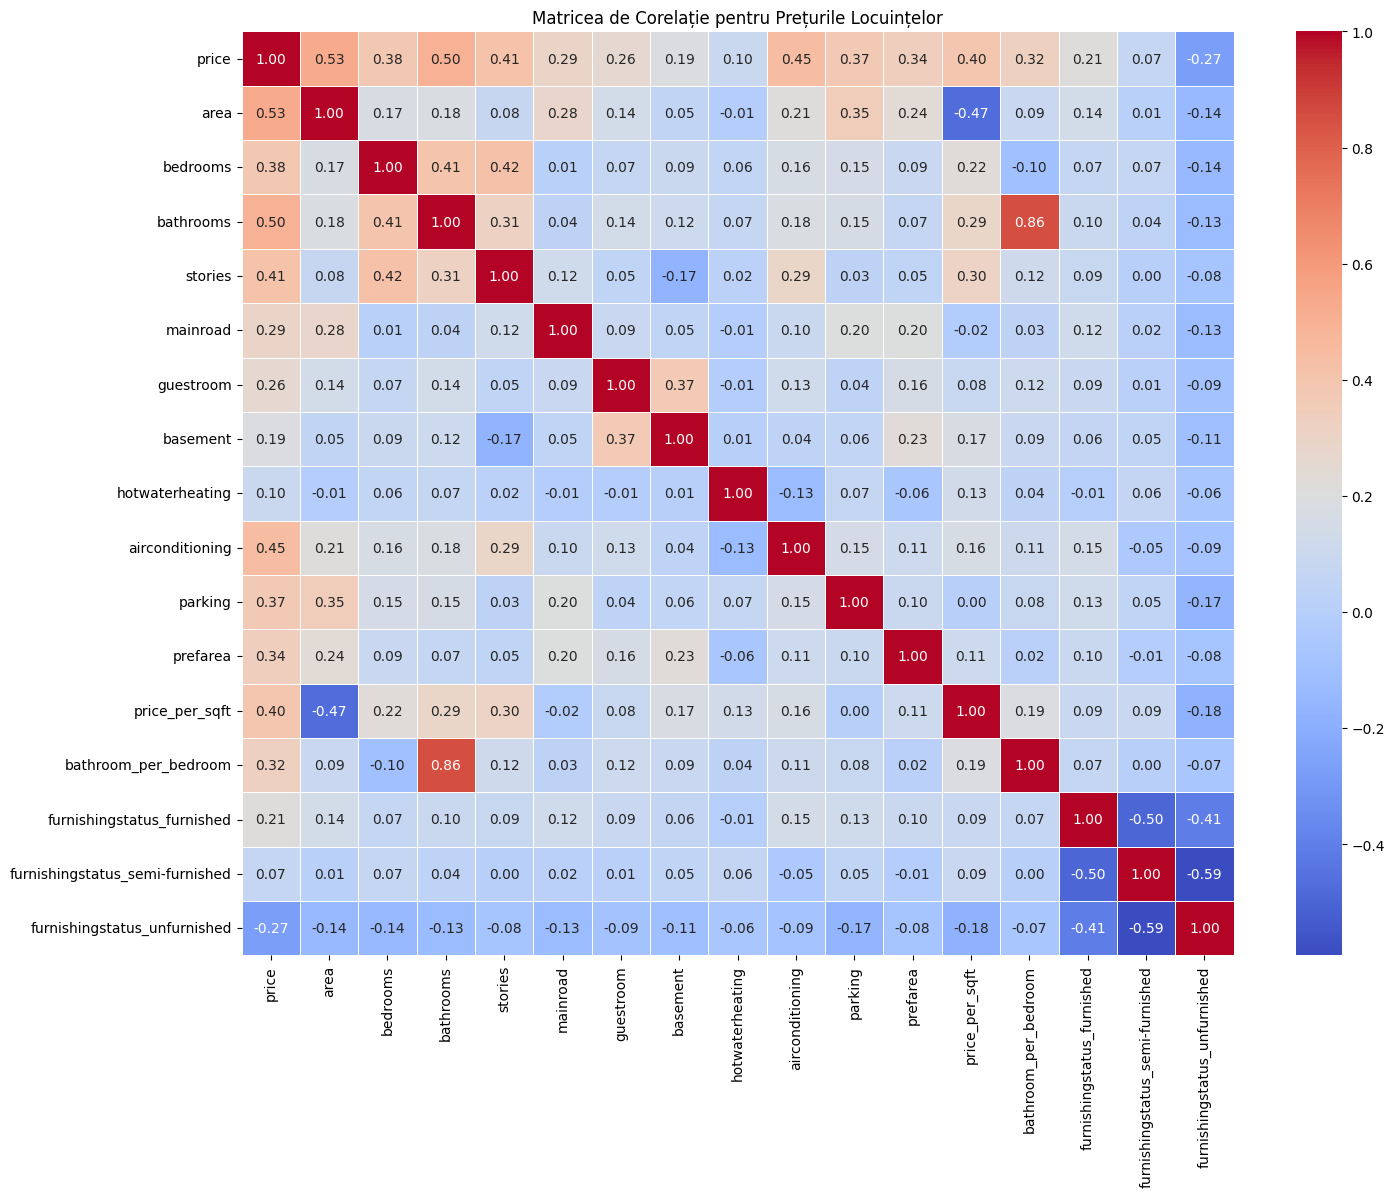

In [140]:
numeric_df = df_no_outliers.select_dtypes(include=["number"])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matricea de Corelație pentru Prețurile Locuințelor")
plt.show()

In [141]:
correlation_with_target = corr_matrix["price"].sort_values(ascending=False)
print("Corelațiile cu 'price':")
print(correlation_with_target)

Corelațiile cu 'price':
price                              1.000000
area                               0.531062
bathrooms                          0.502069
airconditioning                    0.445453
stories                            0.413142
price_per_sqft                     0.395290
bedrooms                           0.384144
parking                            0.372880
prefarea                           0.340305
bathroom_per_bedroom               0.324915
mainroad                           0.294470
guestroom                          0.255692
furnishingstatus_furnished         0.213557
basement                           0.189649
hotwaterheating                    0.096643
furnishingstatus_semi-furnished    0.072279
furnishingstatus_unfurnished      -0.274334
Name: price, dtype: float64


In [142]:
df_no_outliers

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,price_per_sqft,bathroom_per_bedroom,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1792.452830,0.400000,1,0,0
1,12250000,9960,3,2,2,1,0,1,0,0,2,1,1229.919679,0.500000,0,1,0
2,12215000,7500,4,2,2,1,0,1,0,1,3,1,1628.666667,0.400000,1,0,0
3,11410000,7420,4,1,2,1,1,1,0,1,2,0,1537.735849,0.200000,1,0,0
4,10850000,7500,3,3,1,1,0,1,0,1,2,1,1446.666667,0.750000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1820000,3000,2,1,1,1,0,1,0,0,2,0,606.666667,0.333333,0,0,1
535,1767150,2400,3,1,1,0,0,0,0,0,0,0,736.312500,0.250000,0,1,0
536,1750000,3620,2,1,1,1,0,0,0,0,0,0,483.425414,0.333333,0,0,1
537,1750000,2910,3,1,1,0,0,0,0,0,0,0,601.374570,0.250000,1,0,0


In [143]:
key_features = [
    "area",
    "bathrooms",
    "airconditioning",
    "stories",
    "parking",
    "bedrooms",
    "prefarea",
    "price_per_sqft",
    "bathroom_per_bedroom",
]

X = df_no_outliers[key_features]
Y = df_no_outliers["price"]

### Model Training

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

In [145]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#### Log price because xgboost is sensible to unscaled data

In [146]:
Y_train_log = np.log(Y_train).values.reshape(-1, 1)
Y_test_log = np.log(Y_test).values.reshape(-1, 1)

In [147]:
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train_log)
Y_test_scaled = scaler_Y.transform(Y_test_log)

#### Train using XGBoost

In [148]:
xgb_model = xgb.XGBRegressor(random_state=42, objective="reg:squarederror")

param_grid = {
    "n_estimators": [20, 40, 60, 80],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.1, 0.5,
    ],
}

#### Hyperparameter tuning using GridSearchCV

In [149]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5, 
    scoring="neg_mean_squared_error",
    verbose=1,
)

grid_search.fit(X_train_scaled, Y_train_scaled.ravel())

print("Cei mai buni parametri:", grid_search.best_params_)
print("Cel mai bun scor (neg MSE) în validare:", grid_search.best_score_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Cei mai buni parametri: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 80, 'subsample': 0.6}
Cel mai bun scor (neg MSE) în validare: -0.03519196499584702


In [150]:
best_model = grid_search.best_estimator_

Y_pred_scaled = best_model.predict(X_test_scaled)

#### Price restore for evaluating efficiency of model

In [151]:
Y_pred_log = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1))
Y_pred = np.exp(Y_pred_log)  

Y_test_original = np.exp(scaler_Y.inverse_transform(Y_test_scaled))


### Evaluate Model

In [152]:

mse_test = mean_squared_error(Y_test_original, Y_pred)
mae_test = mean_absolute_error(Y_test_original, Y_pred)
r2_original = r2_score(Y_test_original, Y_pred)

print("Scorul pe setul de test (R²) pe scara originală:", r2_original)
print("MSE pe setul de test:", mse_test)
print("MAE pe setul de test:", mae_test)

Scorul pe setul de test (R²) pe scara originală: 0.9570710259765324
MSE pe setul de test: 177282402869.05334
MAE pe setul de test: 235237.14814814777
